In [1]:
print("test")

test


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class GazeDataset(Dataset):
    def __init__(self, csv_file, sequence_length=10):
        self.data = pd.read_csv(csv_file)
        self.sequence_length = sequence_length
        self.data['Name'] = self.data['Name'].astype('category')
        self.data['Label'] = self.data['Name'].cat.codes ##here, Converting  names to numeric labels
        self.labels = self.data['Label'].unique()
        
        #Grouping data by person
        self.groups = self.data.groupby('Label')

        ## Prepare sequences
        self.sequences = []
        self.sequence_labels = []
        
        for label, group in self.groups:
            coords = group[['X', 'Y']].values
            for i in range(len(coords) - self.sequence_length + 1):
                sequence = coords[i:i + self.sequence_length]
                self.sequences.append(sequence)
                self.sequence_labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        label = torch.tensor(self.sequence_labels[idx], dtype=torch.long)
        return sequence, label

## LSTM Model
class GazeLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, num_classes=2):
        super(GazeLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(x.device)
        c0 = torch.zeros(2, x.size(0), 64).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  ## Using the last LSTM output
        return out

In [20]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    train_loss = []
    train_acc = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_loss.append(avg_loss)
        train_acc.append(accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_loss, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_acc, label='Training Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy per Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
# # Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

In [13]:
#Setting Hyperparameters 
sequence_length = 10
batch_size = 16
num_epochs = 2
learning_rate = 0.001


In [9]:
#Loadinggg data
csv_file = '../data/point_data/gaze_data_combined.csv'
dataset = GazeDataset(csv_file, sequence_length=sequence_length)

In [11]:
#Splitting hthe into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Creating Model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GazeLSTM(num_classes=len(dataset.labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/100], Loss: 0.1365, Accuracy: 95.58%
Epoch [2/100], Loss: 0.0966, Accuracy: 96.21%
Epoch [3/100], Loss: 0.0801, Accuracy: 98.11%
Epoch [4/100], Loss: 0.0770, Accuracy: 97.68%
Epoch [5/100], Loss: 0.0721, Accuracy: 97.47%
Epoch [6/100], Loss: 0.0740, Accuracy: 97.89%
Epoch [7/100], Loss: 0.0618, Accuracy: 98.53%
Epoch [8/100], Loss: 0.0987, Accuracy: 96.42%
Epoch [9/100], Loss: 0.0935, Accuracy: 96.63%
Epoch [10/100], Loss: 0.0767, Accuracy: 97.68%
Epoch [11/100], Loss: 0.0772, Accuracy: 98.32%
Epoch [12/100], Loss: 0.0792, Accuracy: 97.47%
Epoch [13/100], Loss: 0.0907, Accuracy: 97.47%
Epoch [14/100], Loss: 0.0786, Accuracy: 97.47%
Epoch [15/100], Loss: 0.0818, Accuracy: 97.05%
Epoch [16/100], Loss: 0.0616, Accuracy: 98.11%
Epoch [17/100], Loss: 0.0617, Accuracy: 98.95%
Epoch [18/100], Loss: 0.0949, Accuracy: 97.89%
Epoch [19/100], Loss: 0.0787, Accuracy: 97.26%
Epoch [20/100], Loss: 0.0585, Accuracy: 98.53%
Epoch [21/100], Loss: 0.0695, Accuracy: 98.11%
Epoch [22/100], Loss: 

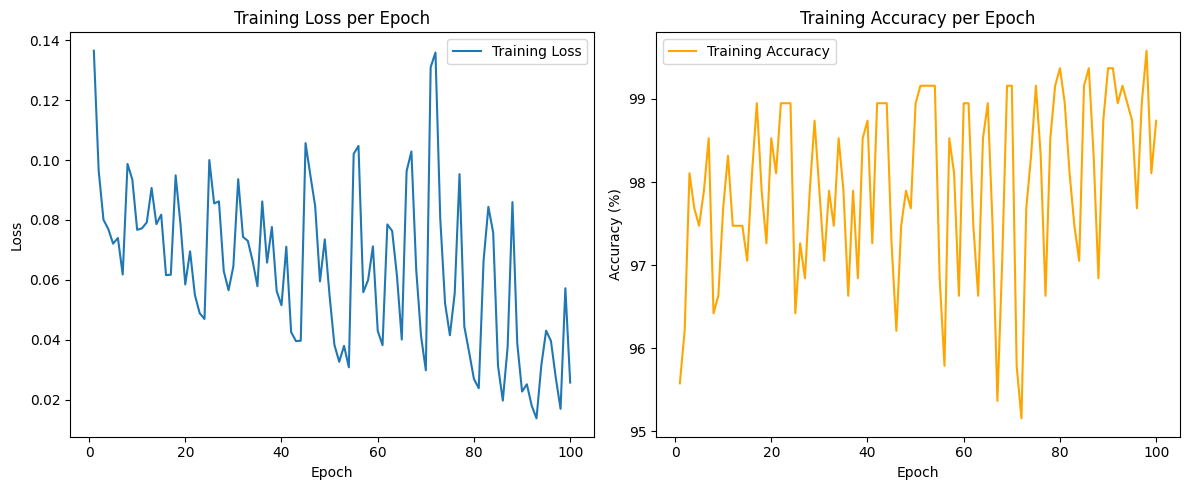

In [23]:
#Training the model the model
train_model(model, train_loader, criterion, optimizer, num_epochs=100)

In [ ]:

### Evaluation of the model
evaluate_model(model, test_loader)

In [2]:
# Saving the model
torch.save(model.state_dict(), 'models/gaze_lstm_model.pth')
print("Model saved as gaze_lstm_model.pth")


NameError: name 'torch' is not defined

In [ ]:
def authenticate_user(gaze_sequence, threshold=0.7):
    """Authenticate a user based on their gaze sequence with confidence threshold."""
    model.eval()
    gaze_sequence = torch.tensor(gaze_sequence, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(gaze_sequence)
        probabilities = torch.softmax(output, dim=1)
        max_prob, predicted_label = torch.max(probabilities, 1)
        
        if max_prob.item() < threshold:
            return False, "Access denied: Low confidence in prediction."
        else:
            return True, f"User authenticated as user ID {predicted_label.item()}."
